## Visualize activation maps to understand which image regions activate CNN filters for emotion detection. 

### Import Libraries

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import warnings
warnings.filterwarnings('ignore')


### Load the Pre-trained Model

#### Here the pre-trained model(my_model_1) is created using FER2013 dataset 

In [12]:
model = load_model(r'C:\Users\USER\Desktop\Emotion Detector\my_model_1.h5')

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,309,065 (4.99 MB)

 Trainable params: 1,308,103 (4.99 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 2 (12.00 B)

### Image Preprocessing Helper Function

In [14]:
def preprocess_image(image_path, target_size=(48, 48)):
    img = load_img(image_path, color_mode='grayscale', target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array, img


### Activation Map Visualization Helper Function

In [15]:
def visualize_activation_maps(model, img_array, layer_names):
    # Create a model to output activations from specified layers
    activation_model = tf.keras.Model(inputs=model.input,
                                       outputs=[model.get_layer(name).output for name in layer_names])
    
    # Get activations
    activations = activation_model.predict(img_array)
    
    # Visualize activation maps
    for i, activation in enumerate(activations):
        num_filters = activation.shape[-1]  # Number of filters in the layer
        size = activation.shape[1]         # Spatial dimensions (height and width)

        # Display a few activation maps
        cols = 8  # Number of columns for plotting
        rows = num_filters // cols if num_filters % cols == 0 else (num_filters // cols) + 1
        fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
        fig.suptitle(f'Activations from layer: {layer_names[i]}', fontsize=16)

        for j in range(num_filters):
            if j >= cols * rows: break  # Avoid plotting more than available space
            row, col = divmod(j, cols)
            ax = axes[row, col] if rows > 1 else axes[col]
            ax.imshow(activation[0, :, :, j], cmap='viridis')  # Show the activation map
            ax.axis('off')

        plt.tight_layout()
        plt.show()


### Main Function to Run the Visualization

In [16]:
def main(image_path):   
    img_array, original_img = preprocess_image(image_path)

    plt.imshow(original_img, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    plt.show()

    # Specify the convolutional layer names for visualization
    layer_names = [layer.name for layer in model.layers if 'conv2d' in layer.name]
    
    visualize_activation_maps(model, img_array, layer_names)


### Run the Visualization

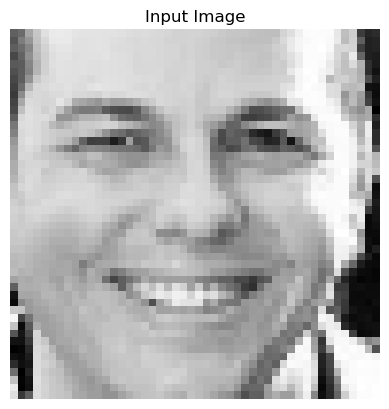

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


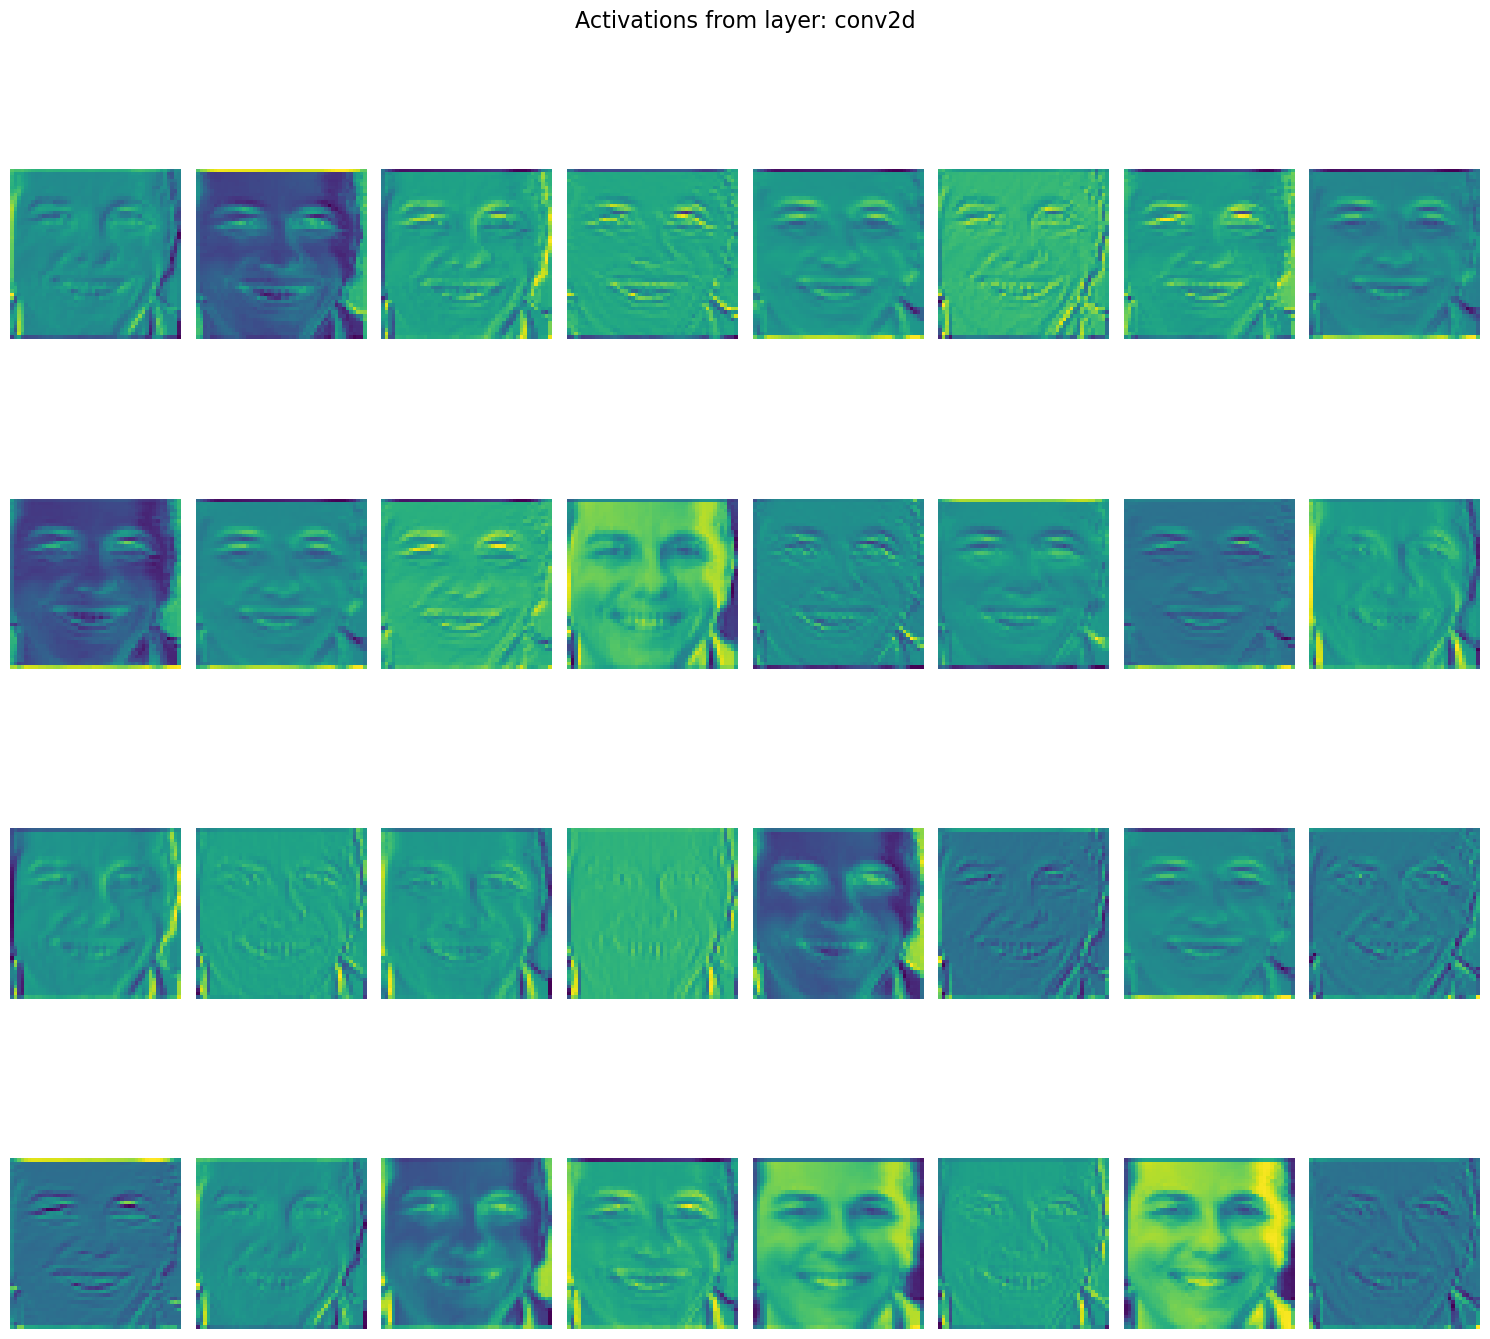

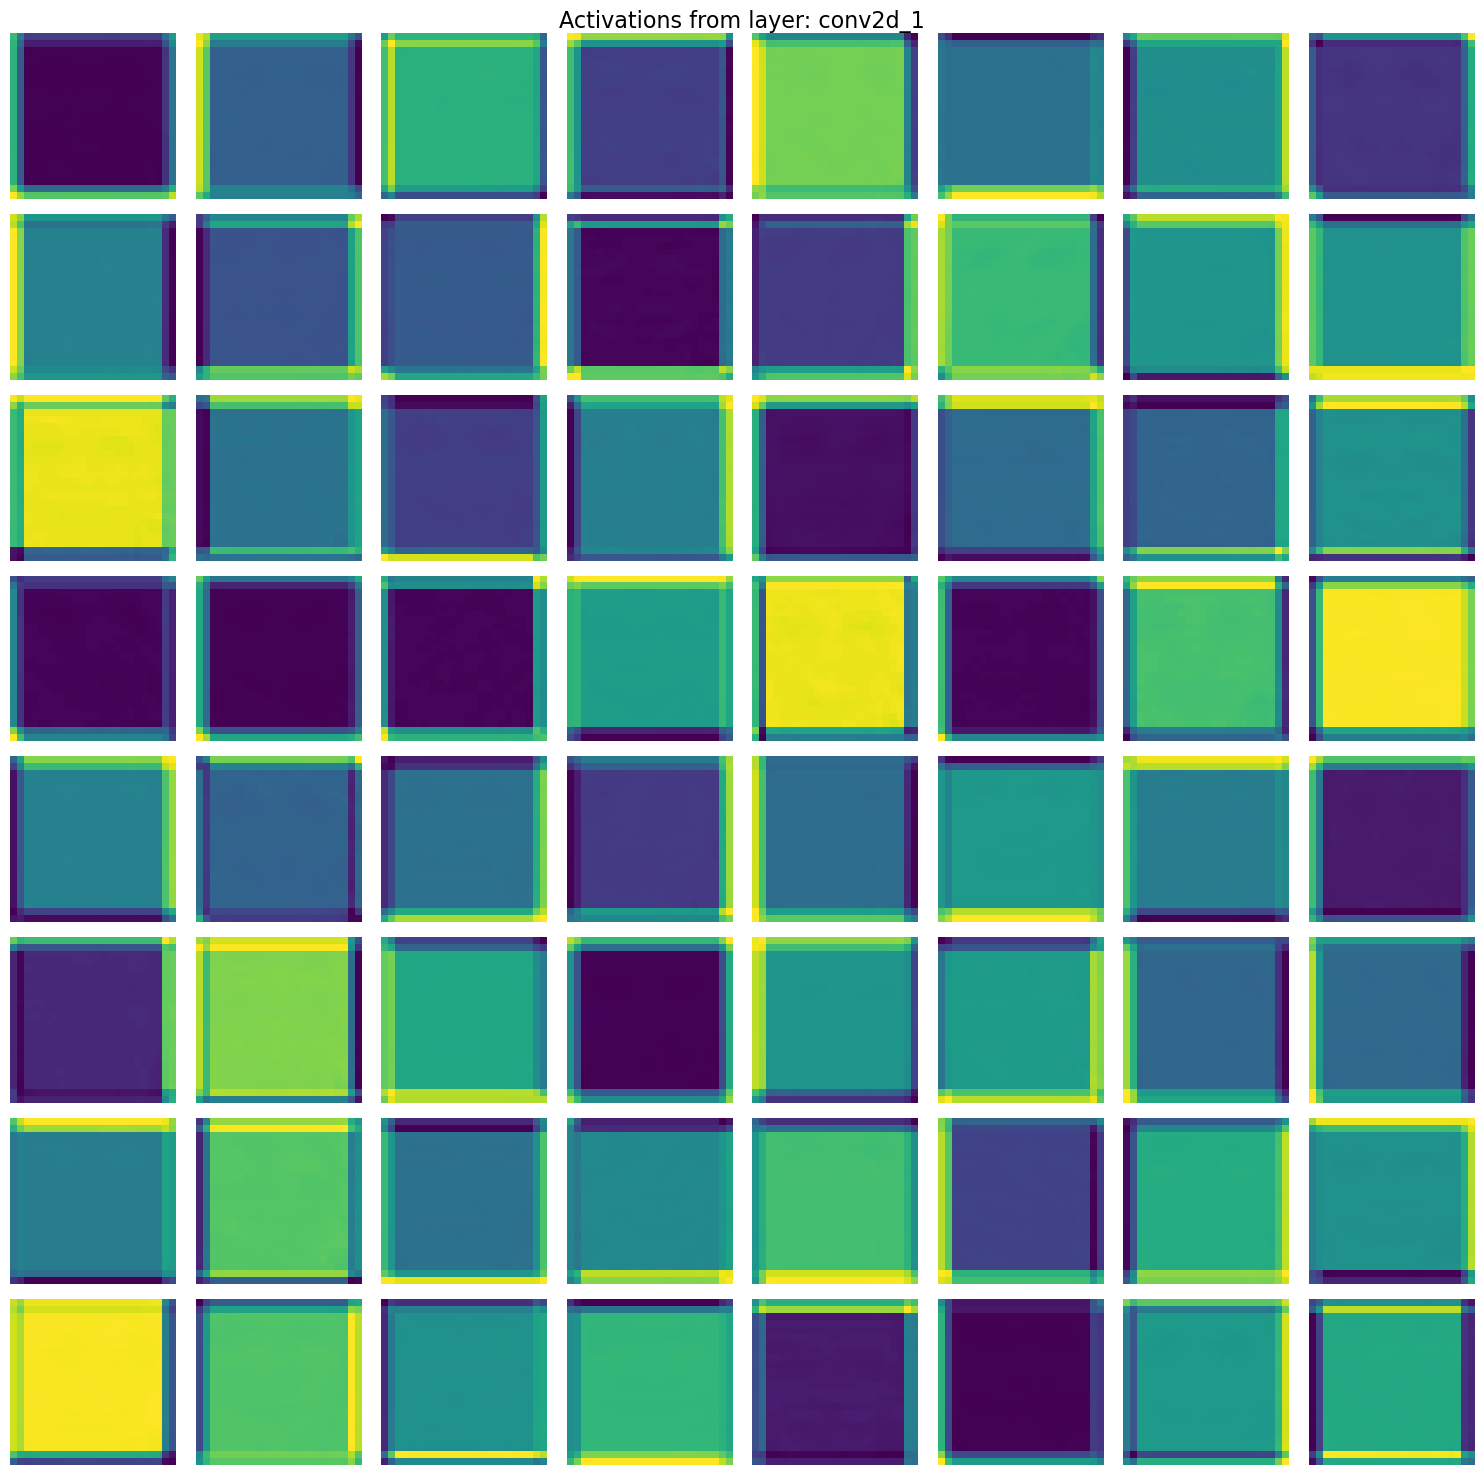

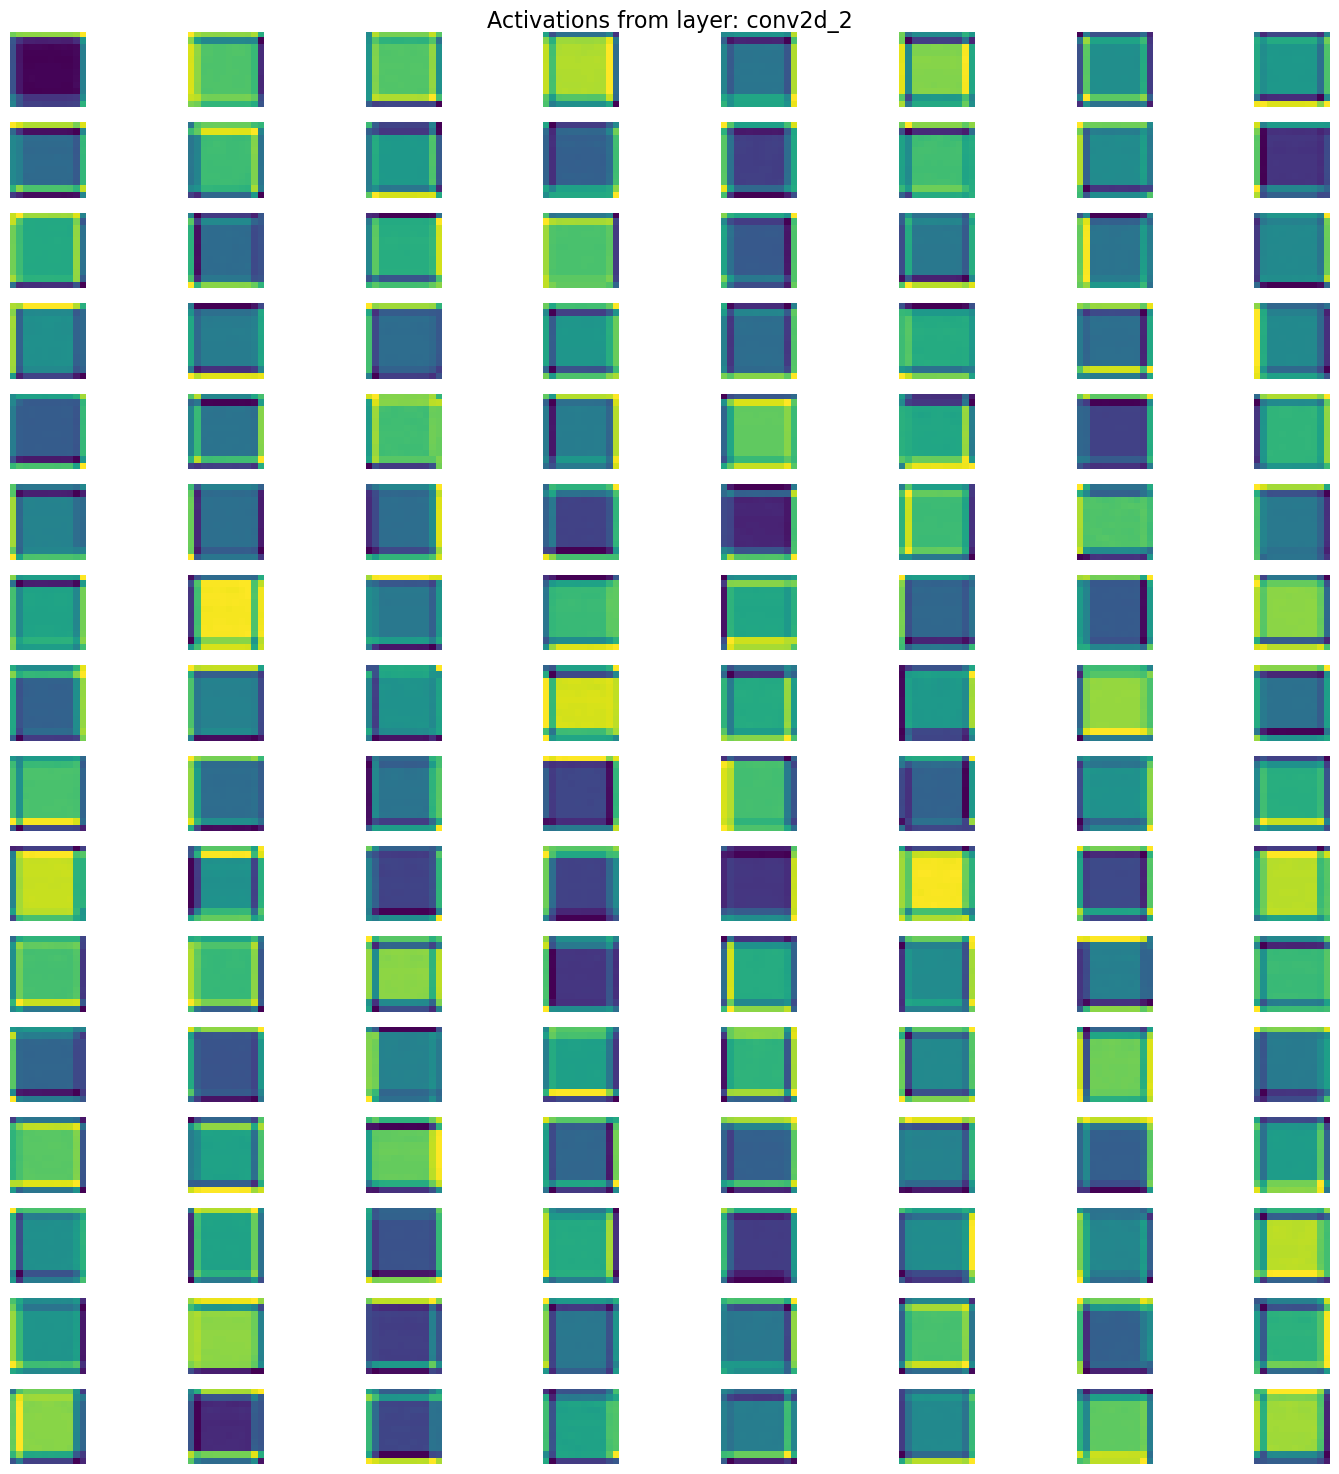

In [17]:
#  path to an input image
image_path = r'C:\Users\USER\Downloads\UTKFace\37_0_0_20170117120612576.jpg.chip.jpg' 
main(image_path)


In [3]:
!pip freeze > requirements.txt


In [8]:
import numpy as np
import matplotlib
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [9]:
with open('requirements.txt', 'w') as f:
    f.write(f"numpy=={np.__version__}\n")
    f.write(f"matplotlib=={matplotlib.__version__}\n")
    f.write(f"tensorflow=={tf.__version__}\n")

print("requirements.txt has been created!")


requirements.txt has been created!


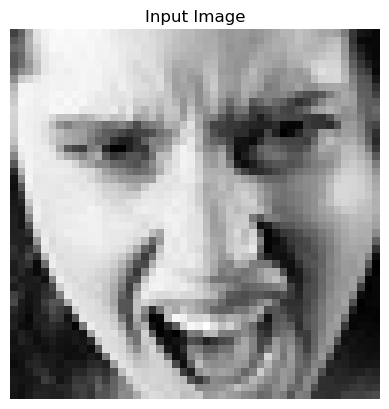

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


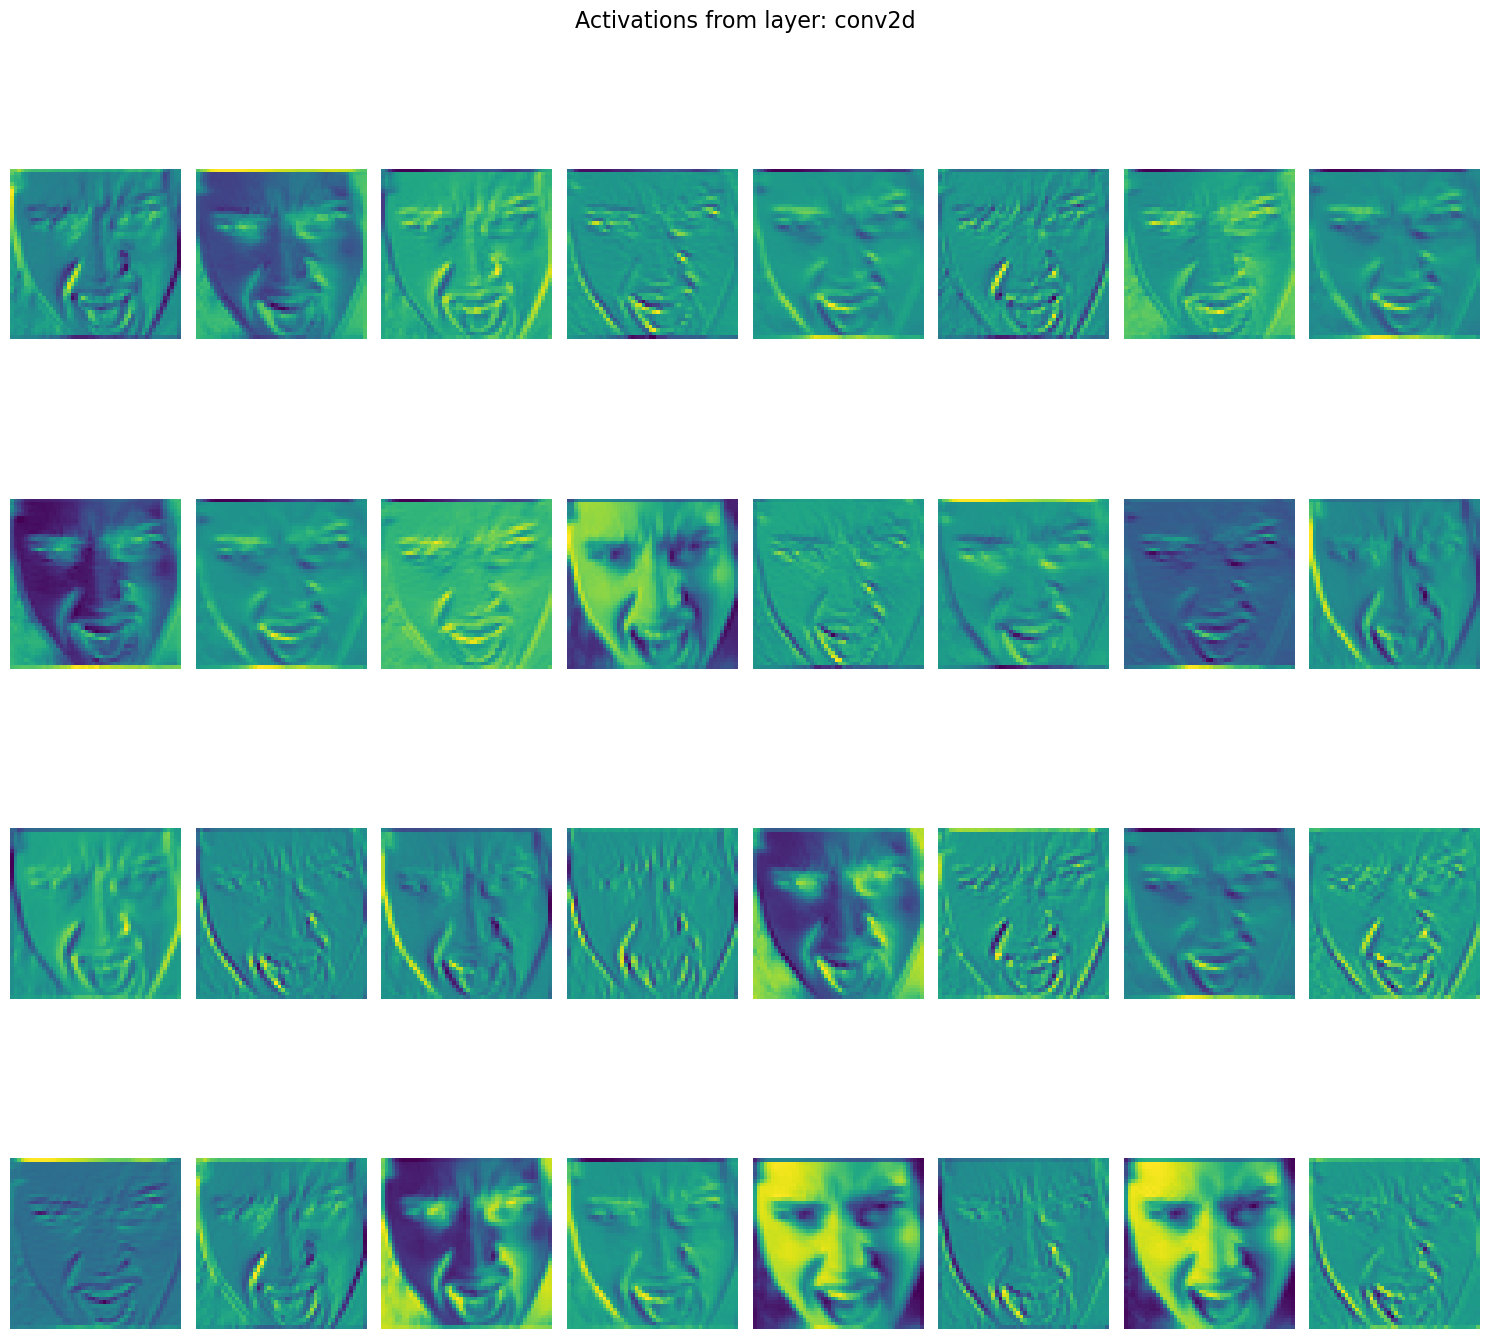

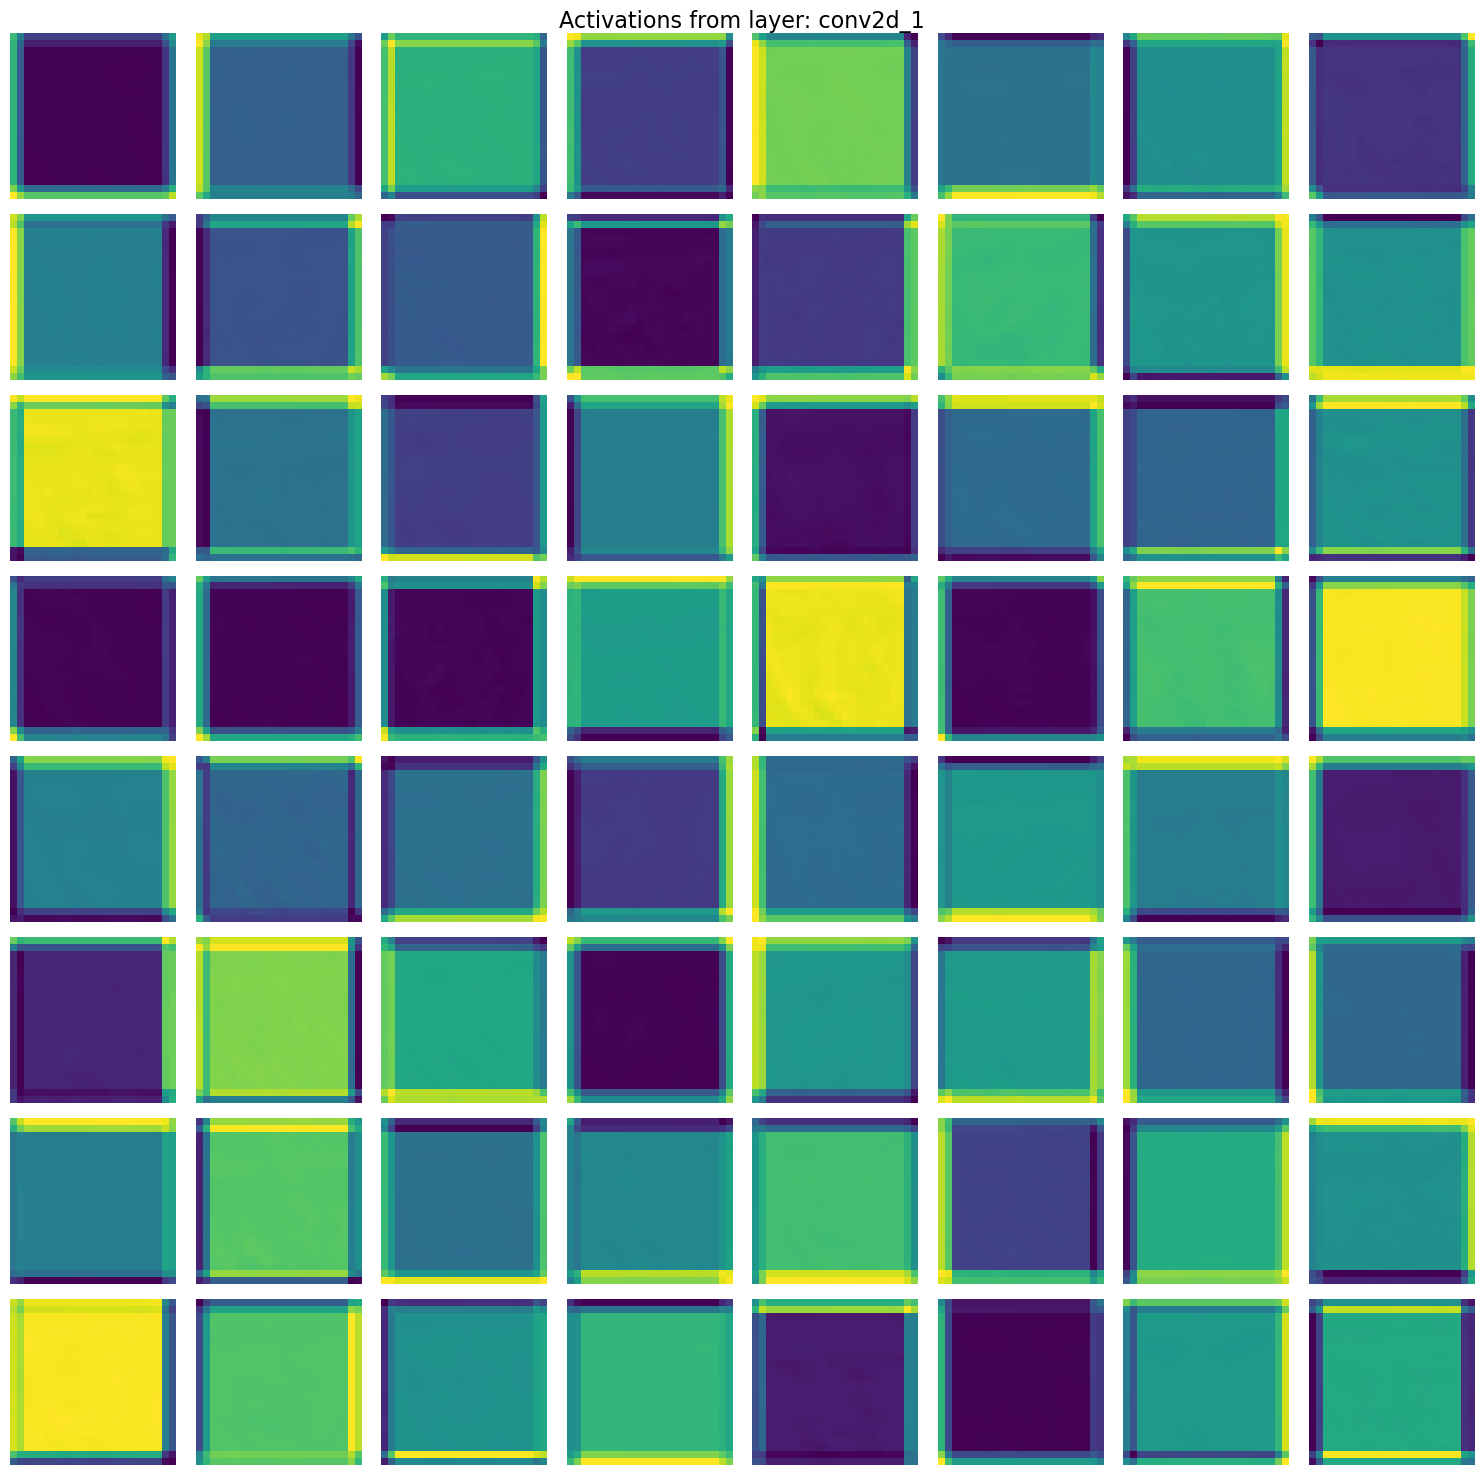

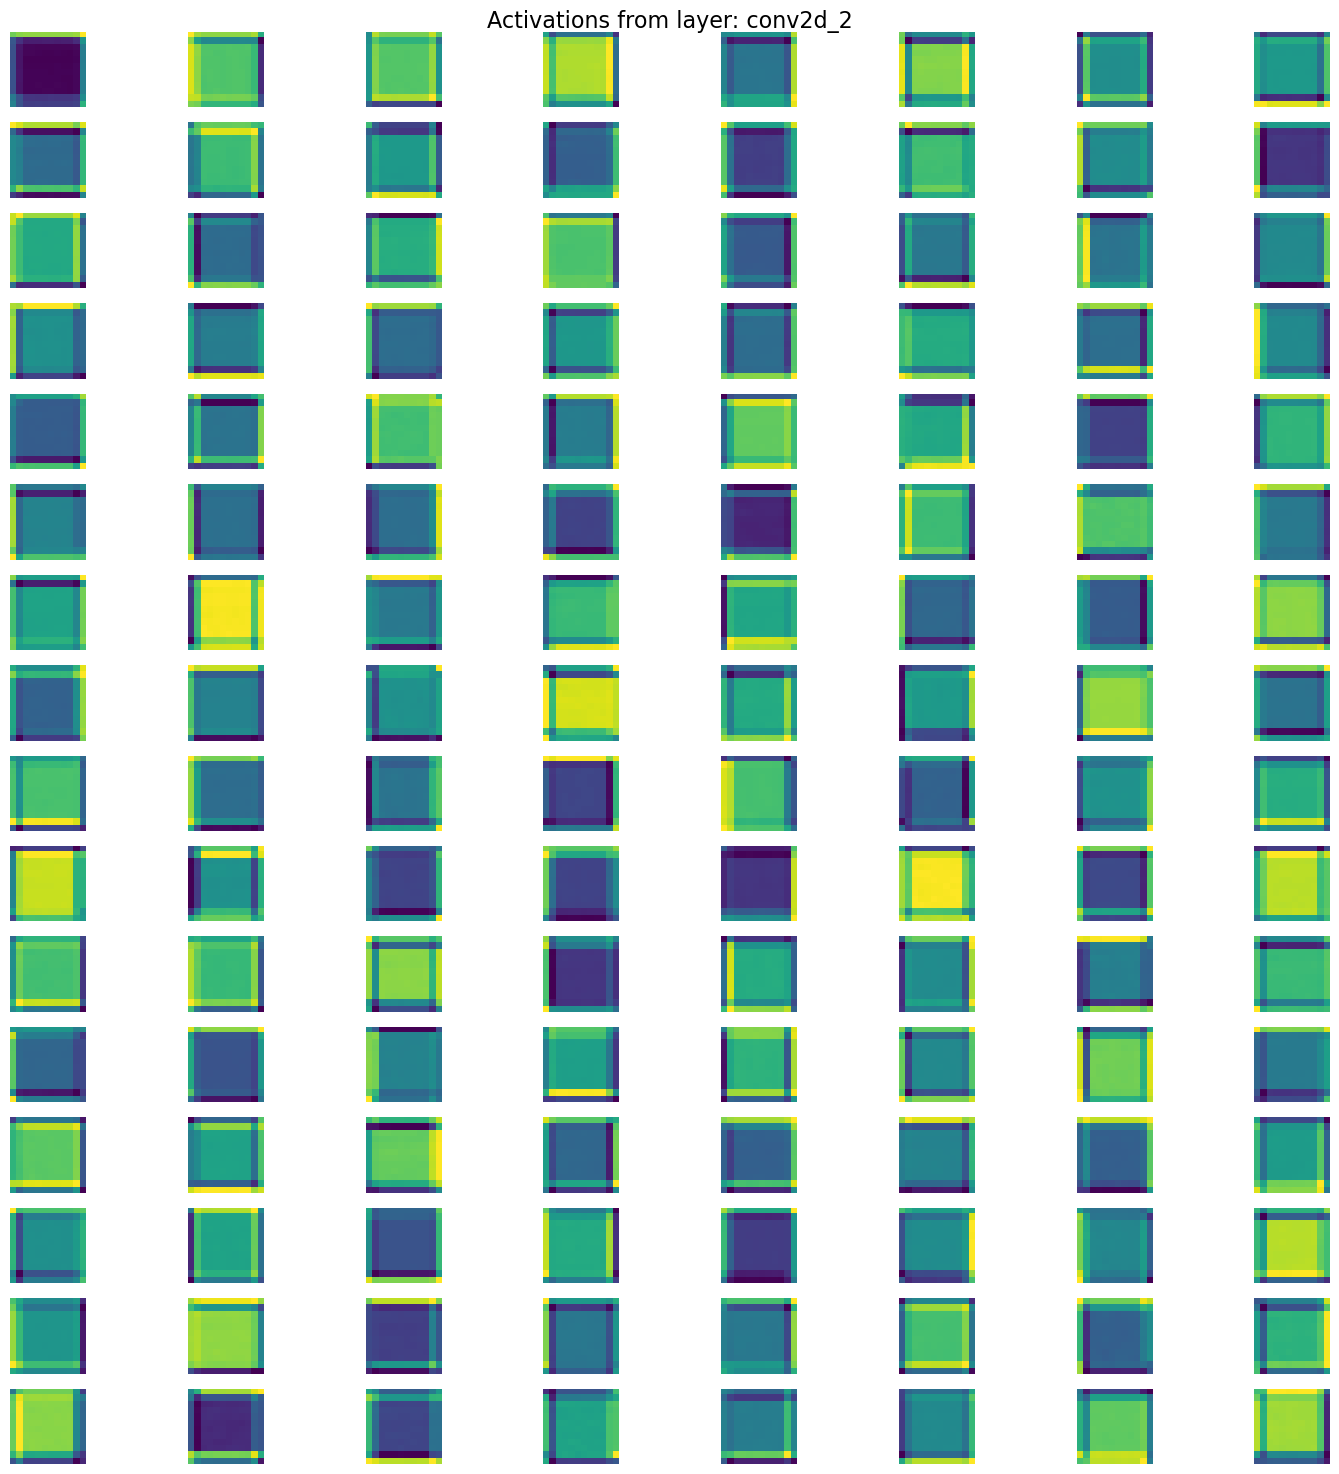

In [2]:
image_path = r'C:\Users\USER\Desktop\Emotion Detector\test\angry\PrivateTest_2775163.jpg' 
main(image_path)
